In [8]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [18]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.today()

tickers = pd.read_csv("omx_tickers.csv", header=None) # as of 2021-03-01
tickers = list(tickers[0])
for i in range(len(tickers)):
    tickers[i] = tickers[i].replace(" ", "-") + ".ST"
print(len(tickers), tickers)

386 ['8TRA.ST', 'AAK.ST', 'ABB.ST', 'ADDT-B.ST', 'AF-B.ST', 'ALFA.ST', 'ALIV-SDB.ST', 'AM1S.ST', 'ARION-SDB.ST', 'ARJO-B.ST', 'ASSA-B.ST', 'ATCO-A.ST', 'ATCO-B.ST', 'ATRLJ-B.ST', 'AXFO.ST', 'AZA.ST', 'AZN.ST', 'BALD-B.ST', 'BEIJ-B.ST', 'BETS-B.ST', 'BHG.ST', 'BILL.ST', 'BOL.ST', 'BRAV.ST', 'BURE.ST', 'CAST.ST', 'CATE.ST', 'CINT.ST', 'DOM.ST', 'EKTA-B.ST', 'ELUX-A.ST', 'ELUX-B.ST', 'EPI-A.ST', 'EPI-B.ST', 'EPRO-B.ST', 'EQT.ST', 'ERIC-A.ST', 'ERIC-B.ST', 'ESSITY-A.ST', 'ESSITY-B.ST', 'EVO.ST', 'FABG.ST', 'FOI-B.ST', 'FPAR-A.ST', 'FPAR-D.ST', 'FPAR-PREF.ST', 'GETI-B.ST', 'HEXA-B.ST', 'HM-B.ST', 'HOLM-A.ST', 'HOLM-B.ST', 'HPOL-B.ST', 'HUFV-A.ST', 'HUSQ-A.ST', 'HUSQ-B.ST', 'ICA.ST', 'INDT.ST', 'INDU-A.ST', 'INDU-C.ST', 'INTRUM.ST', 'INVE-A.ST', 'INVE-B.ST', 'JM.ST', 'KIND-SDB.ST', 'KINV-A.ST', 'KINV-B.ST', 'KLED.ST', 'KLOV-A.ST', 'KLOV-B.ST', 'KLOV-PREF.ST', 'LATO-B.ST', 'LIFCO-B.ST', 'LOOMIS.ST', 'LUMI.ST', 'LUND-B.ST', 'LUNE.ST', 'MCOV-B.ST', 'MYCR.ST', 'NCC-A.ST', 'NCC-B.ST', 'NDA-SE.ST'

In [78]:
OMX = web.DataReader(tickers[0:3], 'yahoo', start, end)
OMX["Open"] = OMX["Open"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"Open":"Adj Open"}, inplace=True)
OMX["High"] = OMX["High"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"High":"Adj High"}, inplace=True)
OMX["Low"] = OMX["Low"] * OMX["Adj Close"] / OMX["Close"]
OMX.rename(columns={"Low":"Adj Low"}, inplace=True)
OMX = OMX[["Adj Open", "Adj High", "Adj Low", "Adj Close", "Volume"]]
OMX = OMX.fillna(0)
OMX

Attributes    Adj Open                            Adj High              \
Symbols        8TRA.ST      AAK.ST      ABB.ST     8TRA.ST      AAK.ST   
Date                                                                     
2010-01-04    0.000000   21.874934  130.921960    0.000000   22.221058   
2010-01-05    0.000000   22.290284  131.395623    0.000000   22.567182   
2010-01-07    0.000000   22.497950  133.574485    0.000000   23.190195   
2010-01-08    0.000000   23.259424  135.942853    0.000000   23.605546   
2010-01-11    0.000000   23.536322  138.974312    0.000000   23.813221   
...                ...         ...         ...         ...         ...   
2021-02-23  234.199997  177.899994  247.000000  237.000000  178.550003   
2021-02-24  231.250000  177.949997  241.100006  236.199997  183.050003   
2021-02-25  235.000000  181.449997  246.000000  240.199997  181.800003   
2021-02-26  234.899994  179.449997  242.600006  238.000000  182.050003   
2021-03-01  237.699997  181.000000  243.800003  242.000000  183.600006   

Attributes                 Adj Low                           Adj Close  \
Symbols         ABB.ST     8TRA.ST      AAK.ST      ABB.ST     8TRA.ST   
Date                                                                     
2010-01-04  131.300903    0.000000   21.598037  130.353566    0.000000   
2010-01-05  132.248235    0.000000   22.221060  131.206159    0.000000   
2010-01-07  135.848087    0.000000   22.359502  133.385020    0.000000   
2010-01-08  137.932266    0.000000   22.982526  135.942853    0.000000   
2010-01-11  139.447980    0.000000   22.913302  136.605970    0.000000   
...                ...         ...         ...         ...         ...   
2021-02-23  247.399994  231.199997  176.750000  238.100006  231.250000   
2021-02-24  245.199997  230.300003  177.949997  241.100006  236.100006   
2021-02-25  246.800003  234.149994  180.199997  243.100006  238.449997   
2021-02-26  244.699997  232.500000  178.500000  241.000000  235.750000   
2021-03-01  246.899994  235.899994  180.600006  243.800003  239.500000   

Attributes                           Volume                       
Symbols         AAK.ST      ABB.ST  8TRA.ST    AAK.ST     ABB.ST  
Date                                                              
2010-01-04   22.151833  131.300903      0.0  196674.0  2356195.0  
2010-01-05   22.359509  131.774567      0.0  232992.0  1081144.0  
2010-01-07   23.190195  135.279694      0.0  445398.0  3910196.0  
2010-01-08   23.397873  137.932266      0.0  360252.0  4170033.0  
2010-01-11   23.743996  137.174377      0.0  513414.0  3959915.0  
...                ...         ...      ...       ...        ...  
2021-02-23  177.850006  240.899994  33442.0  384351.0  2220543.0  
2021-02-24  180.949997  244.699997  40077.0  569442.0  1526122.0  
2021-02-25  181.100006  244.100006  53023.0  418760.0  1370005.0  
2021-02-26  180.949997  241.899994  89099.0  586428.0  1346241.0  
2021-03-01  182.699997  246.199997  20278.0  124901.0   557180.0  

[2802 rows x 15 columns]

In [95]:
data = OMX.to_numpy()

split = 2000
train = data[:split, :]
val = data[split:, :]

trainX = train[:, :]
trainX = train[:-1, :]
trainY = train[:, :4]
trainY = trainY[1:, :]

valX = val[:, :]
valX = val[:-1, :]
valY = val[:, :4]
valY = valY[1:, :]

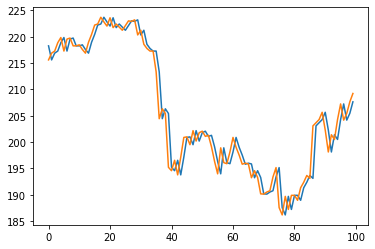

In [102]:
plt.plot(valX[:100, 2])
plt.plot(valY[:100, 2])